In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'augmented-forest-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1650618%2F2738848%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T202440Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De5c28f2cf9a91e4501defffba1e9bbf0fa5991552e16d97a763119150a047e43a79e53395b190c6fbe8e041c51bc34b8754d02fdc8a52c40dee98fc4b768e9d9d509a9cfc86b9b23ce782ff58fecfa8161a4a4d0764c0321be822e37a10f219b63390104be377689565bf191aa4fa15acfbad401b4b07df46ae7d86a8700ae37661991051a22f30a0c944f00cdea5b36acd692c8383470383c04542b4228d8a192cd5608eee286280589cbb0e33175419fbb23ae16760601d96b8bf36addc9746f1b90620b43396f4df43e72ed88c877188263e5838b7ebc24f32ff962a6781ad9a23905d0aa69d23ddfb4a81f126f6ee7ab11b6be55573bcacf879571876d96'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 180628283 bytes downloaded
Downloaded and uncompressed: augmented-forest-segmentation
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/524518_mask_73.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/935318_mask_10.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/182422_mask_62.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/876248_mask_27.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/533952_mask_46.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/111335_mask_01.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/897901_mask_47.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/226788_mask_15.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/7906_mask_87.jpg
/kaggle/input/augmented-

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pandas as pd
from PIL import Image

In [4]:
# Загрузка данных
data_path = '/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented'
meta_data = pd.read_csv(os.path.join(data_path, 'meta_data.csv'))

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [6]:
class ForestDataset(Dataset):
    def __init__(self, meta_data, data_path, transform=None):
        self.meta_data = meta_data
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_path, 'images', self.meta_data.iloc[idx, 0])
        mask_name = os.path.join(self.data_path, 'masks', self.meta_data.iloc[idx, 1])

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')

        image = self.transform(image)
        mask = transforms.Resize((256, 256))(mask)
        mask = self.transform(mask)

        return image, mask

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

forest_dataset = ForestDataset(meta_data, data_path, transform)
train_loader = DataLoader(forest_dataset, batch_size=8, shuffle=True)

In [8]:
# Модель UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = models.vgg11_bn(pretrained=True).features[:17]

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x = self.decoder(x1)
        return x

In [9]:
model = UNet()

# Loss и оптимизатор
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:02<00:00, 201MB/s]


In [30]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        # Up-sample mask to match the size of the input images
        masks = torch.nn.functional.interpolate(masks, size=outputs.shape[-2:], mode='bilinear')
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')


Epoch 1, Loss: 0.38970366278911045
Epoch 2, Loss: 0.38420100127680573
Epoch 3, Loss: 0.3762671017963935
Epoch 4, Loss: 0.3665896843949767
Epoch 5, Loss: 0.35474583928667136
Epoch 6, Loss: 0.3416472037959733
Epoch 7, Loss: 0.32351230644564116
Epoch 8, Loss: 0.29886002467831535
Epoch 9, Loss: 0.2738990670125436
Epoch 10, Loss: 0.24238945403849016
Epoch 11, Loss: 0.2193901046107819
Epoch 12, Loss: 0.19383219184123668
Epoch 13, Loss: 0.17428857576632537
Epoch 14, Loss: 0.15791471117119274
Epoch 15, Loss: 0.1479134417615586


In [31]:
torch.save(model.state_dict(), 'weights15_for_unet.pth')

In [32]:
torch.save(model, 'unet15.pth')

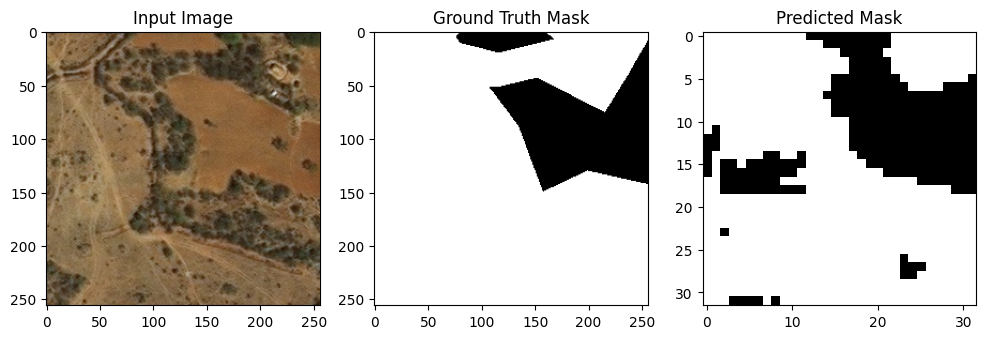

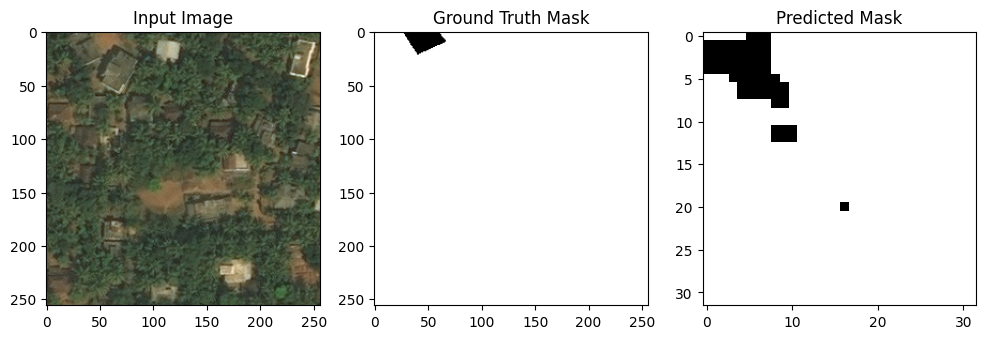

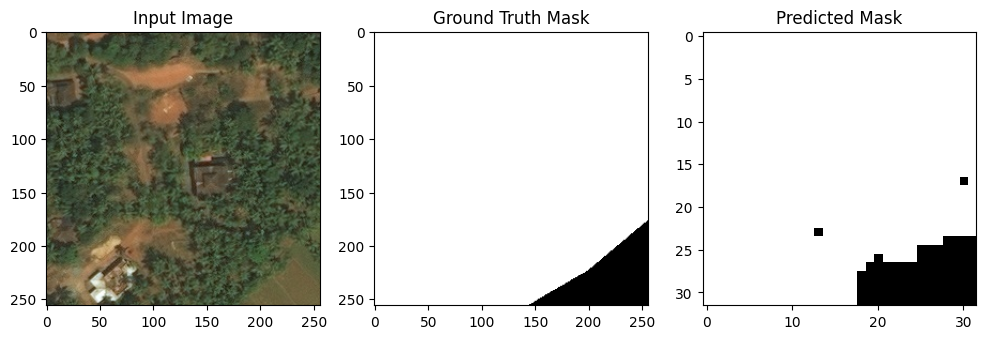

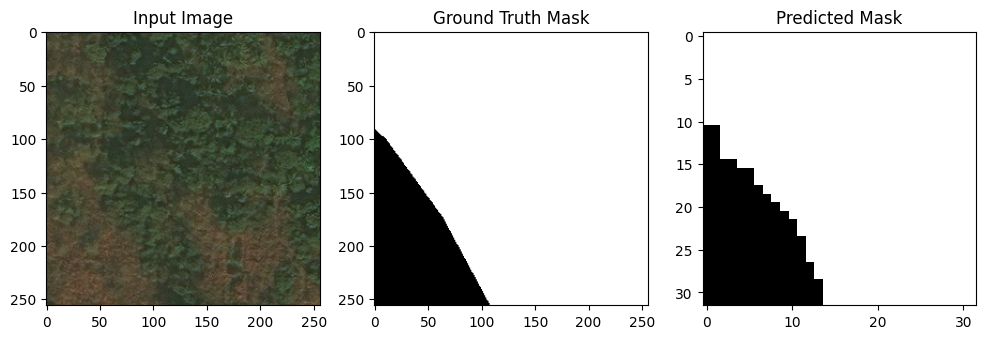

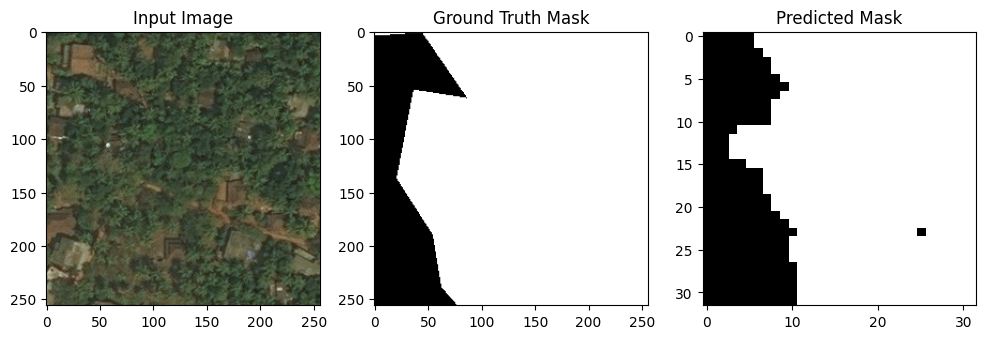

In [33]:
import matplotlib.pyplot as plt

model.eval()
test_dataset = ForestDataset(meta_data, data_path, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        outputs = model(images)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        image = images.squeeze().permute(1, 2, 0)
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        mask = masks.squeeze()  # No need to permute for 2D image
        mask = (mask > 0.5).float()  # Convert mask to binary
        plt.imshow(mask, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        predicted_mask = outputs.squeeze()  # No need to permute for 2D image
        predicted_mask = (predicted_mask > 0.5).float()  # Convert mask to binary
        plt.imshow(predicted_mask, cmap='gray')

        plt.show()

        if i == 4:
            break  # Visualize only 5 samples for brevity

